In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from scipy.stats import norm
from numpy import linalg as LA
import time

def lotka_volterra(N, alpha):
    interaction_term = np.dot(alpha, N)
    dNdt = N * (1 - N) - N * interaction_term
    return dNdt

def rk4_step(f, N, t, dt, h):
    k1 = f(N, h)
    k2 = f(N + 0.5 * dt * k1, h)
    k3 = f(N + 0.5 * dt * k2, h)
    k4 = f(N + dt * k3, h)
    return N + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

def solve_lotka_volterra(alpha, N0, t_max, dt):
    t_values = np.arange(0, t_max, dt)
    N_values = np.zeros((len(t_values), len(N0)))
    N_values[0] = N0
    for i in range(1, len(t_values)):
        N_values[i] = rk4_step(lotka_volterra, N_values[i-1], t_values[i-1], dt, alpha)
    return t_values, N_values

def solve_lotka_volterra_perturb(alpha, N0, epsilon,t_epsilon, t_max, dt):
    t_values1 = np.arange(0, t_epsilon - dt, dt)
    x = len(t_values1)
    t_values2 = np.arange(t_epsilon, t_max, dt)
    t_values = np.concatenate((t_values1, t_values2))
    N_values = np.zeros((len(t_values), len(N0)))
    N_values[0] = N0
    for i in range(1, x):
        N_values[i] = rk4_step(lotka_volterra, N_values[i-1], t_values[i-1], dt, alpha)
    N_values[x] = N_values[x-1]+epsilon
    for j in range(1, len(t_values2)):
        N_values[x + j] = rk4_step(lotka_volterra, N_values[x + j-1], t_values[x + j-1], dt, alpha)
    return t_values, N_values
    
def alphagen(mu,sigma, S):
    Alpha = np.random.normal(mu/S, sigma/np.sqrt(S), size=(S, S))
    np.fill_diagonal(Alpha, 0)
    return Alpha

def Mixture_matrix(S,mu,sigma,c):
    G = nx.erdos_renyi_graph(S, c/S)
    adj_matrix = nx.to_numpy_array(G)
    alpha = np.random.normal(mu/c , sigma/(np.sqrt(c)),size=(S,S))
    interaction_matirx = adj_matrix * alpha
    np.fill_diagonal(interaction_matirx, 0)
    return interaction_matirx

def antagonistic_matrix(S2, c2, mu2, sigma2):
    G2 = nx.erdos_renyi_graph(S2, c2/S2)
    adj_matrixG2 = nx.to_numpy_array(G2)
    weights = np.random.normal(mu2/c2 , sigma2/(np.sqrt(c2)),size=(S2,S2))
    np.fill_diagonal(weights, 0)
    Antagonistic_Matrix = adj_matrixG2*weights
    for i in range(S2):
        for j in range(i + 1, S2):  
            if Antagonistic_Matrix[i, j]*Antagonistic_Matrix[j, i] > 0:
                if np.random.rand() > 0.5:
                    Antagonistic_Matrix[i, j] = -Antagonistic_Matrix[i, j]
                else:
                    Antagonistic_Matrix[j, i] = -Antagonistic_Matrix[j, i]
    return Antagonistic_Matrix

def gLV_Jacobean3(Alpha,N):
    daigs = np.diag(N)
    Jacobean = -np.matmul(daigs,Alpha)
    M = np.matmul(Alpha,N)
    for i in range(len(N)):
        Jacobean[i][i] = 1 - 2*N[i] - M[i]
    return Jacobean

def gLV_Jacobean2(Alpha,N):
    Jacobean = np.zeros_like(Alpha)
    for i in range(len(N)):
        for j in range(len(N)):
            if i == j:
                M = np.matmul(Alpha,N)
                Jacobean[i][j] = 1 - 2*N[i] - M[i]
            else: 
                Jacobean[i][j] = -N[i]*Alpha[i][j]
    return Jacobean


def LargestEigenValue(J):
    eigs = LA.eigvals(J)
    real_eigs = []
    for i in eigs:
        real_eigs.append(i.real)
    return max(real_eigs) 

def get_sigJ(Jac):
    S = len(Jac[0])
    np.fill_diagonal(Jac, 0)
    meanlist = []
    varlist = []
    for i in range(len(Jac[0])):
        for j in range(len(Jac[0])):
            meanlist.append(Jac[i,j])
            varlist.append(Jac[i,j]**2)
    mean = sum(meanlist)/(S*(S-1))
    varience = sum(varlist)/(S*(S-1))
    return np.sqrt(varience)
   
def May_matrix(J):
    S = len(J[0])
    d = np.trace(J)/S
    print("D = ", d)
    Jac = J
    np.fill_diagonal(Jac, 0)
    meanlist = []
    varlist = []
    for i in range(len(Jac[0])):
        for j in range(len(Jac[0])):
            meanlist.append(Jac[i,j])
            varlist.append(Jac[i,j]**2)
    mean = sum(meanlist)/(S*(S-1))
    print("mean = ", mean)
    varience = sum(varlist)/(S*(S-1))
    print("varience = " , varience)
    Mmatrix = np.random.normal(0, np.sqrt(varience),size=(S,S))
    np.fill_diagonal(Mmatrix, d)
    return Mmatrix

def get_mometns_eigenvalues(J,n):
    S = len(J[0])
    Eigenvalues = LA.eigvals(J)
    mom = sum(Eigenvalues**n)/S
    return mom.real

def alphagen_withGamma(mu,sigma,gamma,S):
    Alpha = np.zeros((S,S))
    variance = (sigma**2)/S 
    mean = mu/S 
    cov_ab = (gamma * sigma**2) / S
    covariance_matrix = [[variance, cov_ab],
                         [cov_ab, variance]]
    means = [mean, mean]
    for i in range(S):
        for j in range(i + 1, S):
            ab_values = np.random.multivariate_normal(means, covariance_matrix,1)
            a = ab_values[:,0]
            b = ab_values[:,1]
            Alpha[i,j] = a[0]
            Alpha[j,i] = b[0]
    return Alpha

def get_real_distribution_plot(Jacobean):
    Eigenvalues = LA.eigvals(Jacobean)
    real_eigenvalues = []
    for i in Eigenvalues:
        real_eigenvalues.append(i.real) 
    plt.figure(figsize=(10, 6))
    plt.hist(real_eigenvalues, bins=30, edgecolor='black', alpha=1)
    plt.grid(True)
    plt.show()

In [3]:
S = 500
mu = 4
sigma = 1
t_max = 500
dt = 0.05
N0 = np.random.uniform(0, 1, size=S)

/var/folders/zm/5zxxsy2d75bdst_608fxx_hh0000gn/T/ipykernel_9252/4243534764.py:10: RuntimeWarning: overflow encountered in multiply
  dNdt = N * (1 - N) - N * interaction_term
/var/folders/zm/5zxxsy2d75bdst_608fxx_hh0000gn/T/ipykernel_9252/4243534764.py:10: RuntimeWarning: invalid value encountered in subtract
  dNdt = N * (1 - N) - N * interaction_term


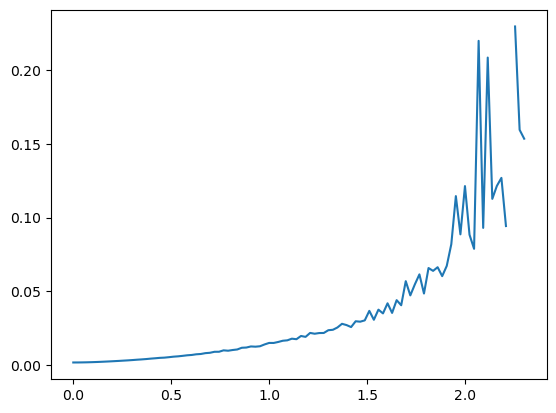

In [12]:
sigs = np.linspace(0,2,50)

Sjss = []
for i in sigs:
    alpha = Mixture_matrix(S,mu,sigma,c)
    ts, Ns = solve_lotka_volterra(alpha, N0, t_max, dt)
    Jacobean = gLV_Jacobean3(alpha,Ns[-1])
    SJ = get_sigJ(Jacobean)
    Sjss.append(SJ)

plt.plot(sigs,Sjss)
plt.show()



KeyboardInterrupt: 

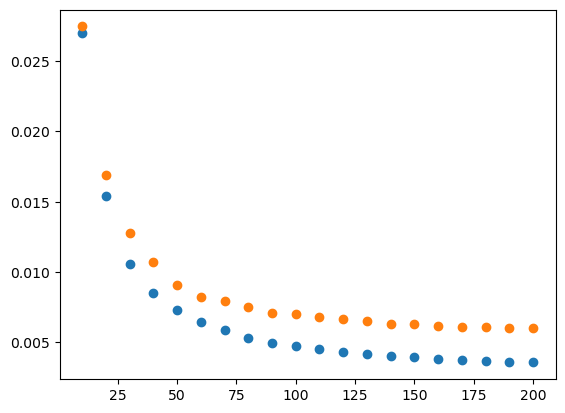

In [43]:
cs = list(range(200,0,-10))

for sig in [0.25,0.5,1,1.5,2]:
    Sjss = []
    for c in cs:
        alpha = Mixture_matrix(S,mu,sig,c)
        ts, Ns = solve_lotka_volterra(alpha, N0, t_max, dt)
        Jacobean = gLV_Jacobean3(alpha,Ns[-1])
        SJ = get_sigJ(Jacobean)
        Sjss.append(SJ)
    plt.scatter(cs, Sjss, label = f"sigma = {sig}")

plt.legend()
plt.xlabel(r'connectivity $c$')
plt.ylabel(r'$\sigma_J$')
plt.show()


## Eigenvalue distribution

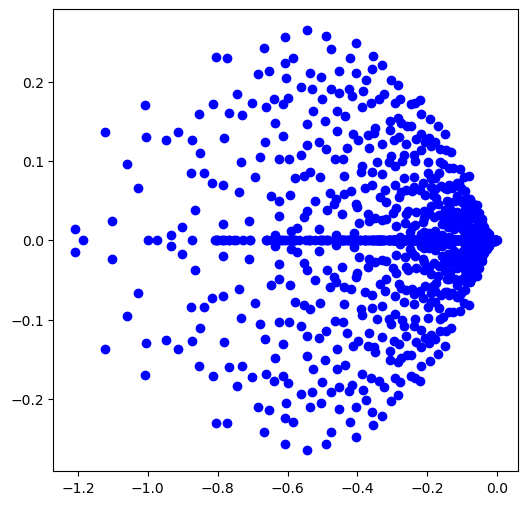

-0.2987207979422243
D =  -0.29872079794222384
mean =  -0.0007217996242247181
varience =  0.0001099694722190338


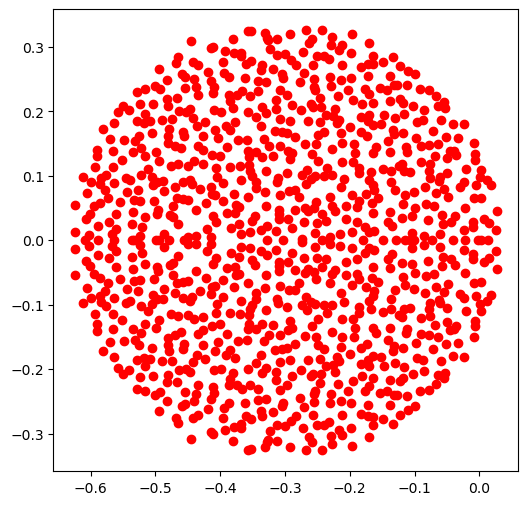

In [23]:
#Eigenvalues distribution plot plots

plt.figure(figsize=(6, 6))
Eigies = LA.eigvals(Jacobean)
plt.scatter(Eigies.real,Eigies.imag, color='blue')
plt.show()

mabbsdvs = get_mometns_eigenvalues(Jacobean,1)
print(mabbsdvs)

Mn = May_matrix(Jacobean)
plt.figure(figsize=(6, 6))
Es = LA.eigvals(Mn)
plt.scatter(Es.real,Es.imag, color='red')
plt.show()




    

For gamma = -1


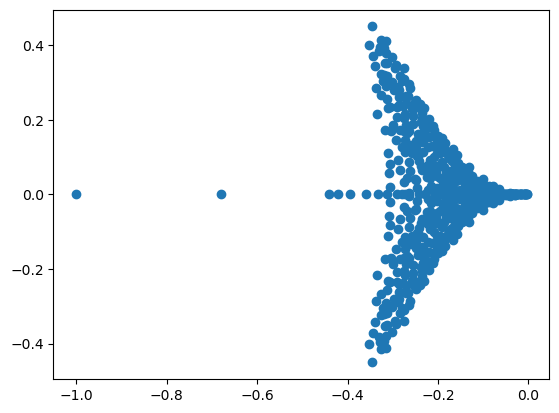

For gamma = -0.75


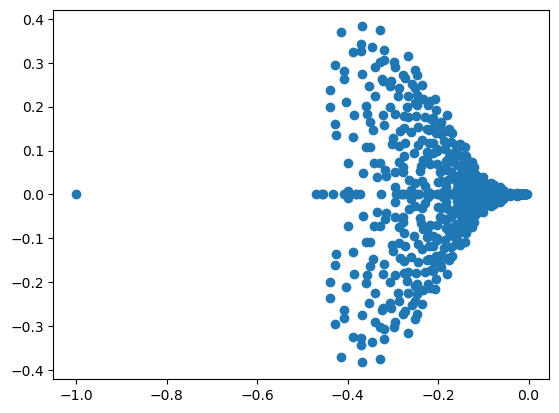

For gamma = -0.5


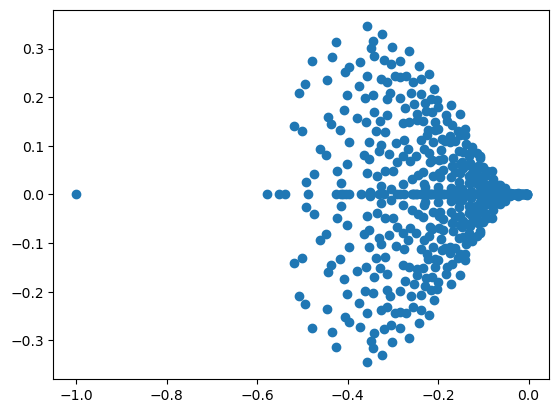

For gamma = -0.25


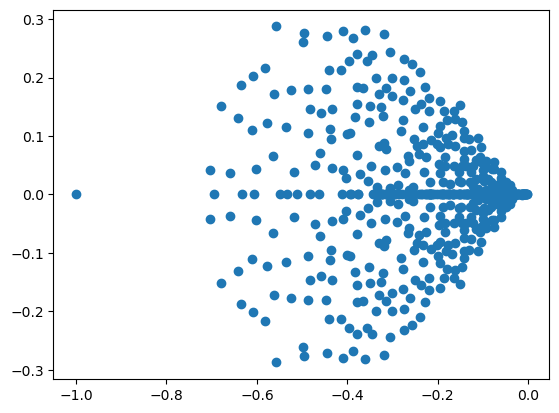

For gamma = 0


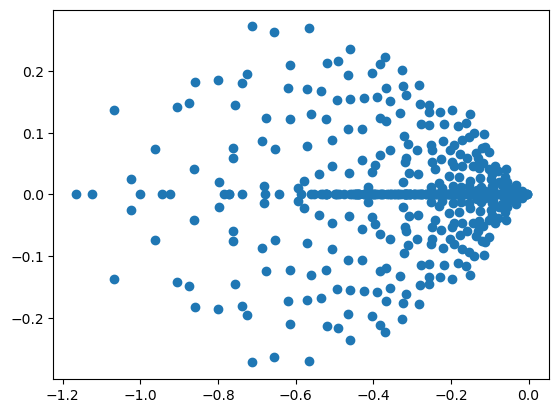

For gamma = 0.25


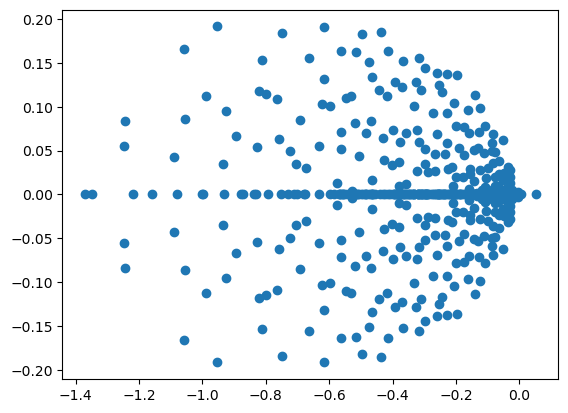

For gamma = 0.5


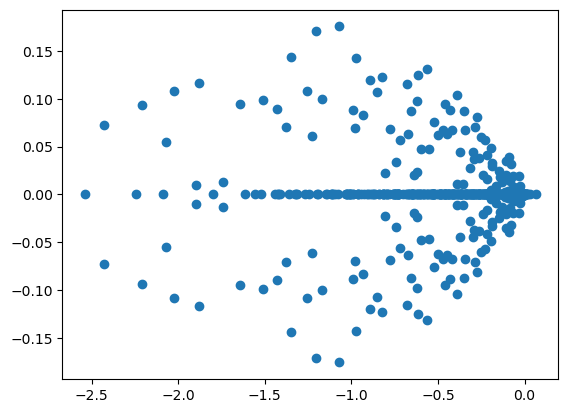

For gamma = 0.75


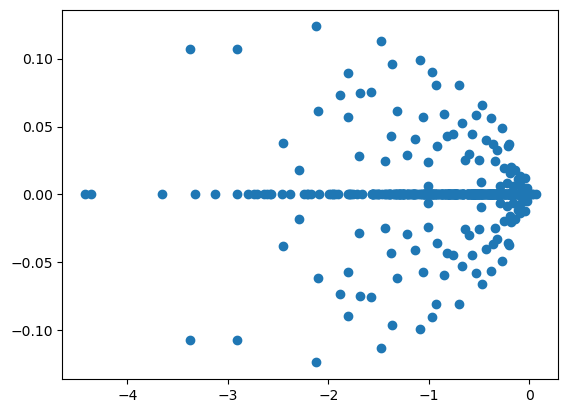

For gamma = 1


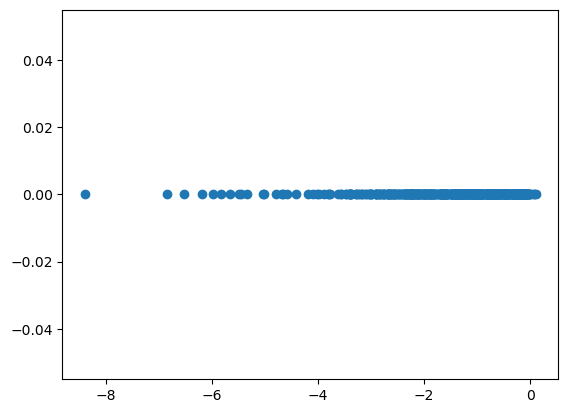

In [8]:
S = 500
mu = 4
sigma = 1
t_max = 500
dt = 0.05
N0 = np.random.uniform(0, 1, size=S)
Gammas = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]

for gamma in Gammas:
    alpha = alphagen_withGamma(mu,sigma,gamma,S)
    ts, Ns = solve_lotka_volterra(alpha, N0, t_max, dt)
    Jacobean = gLV_Jacobean3(alpha,Ns[-1])
    Eigies = LA.eigvals(Jacobean)
    print(f"For gamma = {gamma}")
    plt.scatter(Eigies.real,Eigies.imag)
    plt.show()

### Other

For sigma = 0.00
-1.6158688027644104
For sigma = 0.04
-1.7570106172925946
For sigma = 0.08
-1.9365299613898463
For sigma = 0.12
-2.029664431754386
For sigma = 0.16
-2.4802631864810616
For sigma = 0.20
-2.8395667325255807
For sigma = 0.24
-2.596828703384532
For sigma = 0.29
-3.2111843904408754
For sigma = 0.33
-5.3670298407289545
For sigma = 0.37
-4.7906997408165966
For sigma = 0.41
-5.463089982317932
For sigma = 0.45
-6.218868097006424
For sigma = 0.49
-5.902921558223179
For sigma = 0.53
-6.225485643671507
For sigma = 0.57
-6.297579127024028
For sigma = 0.61
-6.198507909849767
For sigma = 0.65
-6.19899134128028
For sigma = 0.69
-6.220074952977431
For sigma = 0.73
-6.3268170387848075
For sigma = 0.78
-6.193124086291468
For sigma = 0.82
-6.369354114446632
For sigma = 0.86
-6.163345814351005
For sigma = 0.90
-6.410740945312653
For sigma = 0.94
-5.925220944019049
For sigma = 0.98
-6.196007890021149
For sigma = 1.02
-6.155462299065
For sigma = 1.06
-6.463196348166656
For sigma = 1.10
-6.406

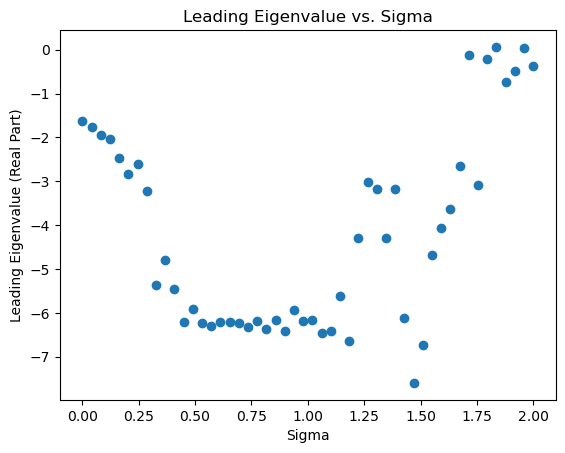

In [37]:
#Leading Eigen value for differnt sigma
sigs = np.linspace(0,2,50)
N0 = np.random.uniform(0, 1, size=500)

leads = []
for i in sigs:
    alpha = alphagen(4,i, 500)
    ts, Ns = solve_lotka_volterra(alpha, N0, 1000, 0.05)
    Jacobean = gLV_Jacobean3(alpha,Ns[-1])
    eigs = LA.eigvals(Jacobean)
    Rs = eigs.real
    big = np.log(abs(np.max(Rs)
    leads.append(big)
    print(f"For sigma = {i:.2f}")

plt.scatter(sigs, leads)
plt.xlabel("Sigma")
plt.ylabel("Leading Eigenvalue (Real Part)")
plt.title("Leading Eigenvalue vs. Sigma")
plt.show()
    

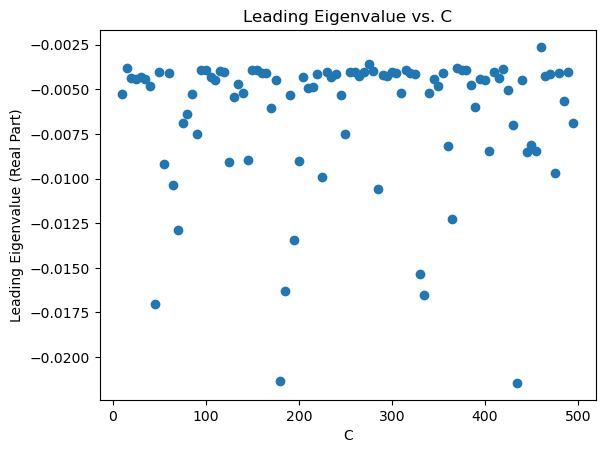

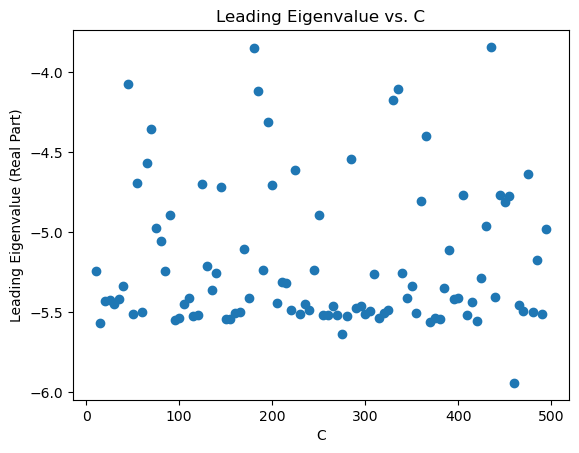

In [11]:
# Exploring jacobean for different cvalues 
cs = list(range(10, 500, 5))

S = 500
mu = 0.5
sigma = 0.5
t_max = 500
dt = 0.05

N0 = np.random.uniform(0, 1, size=S)

leads = []
logs = []
for c in cs:
    alpha = Mixture_matrix(S,mu,sigma,c)
    ts, Ns = solve_lotka_volterra(alpha, N0, t_max, dt)
    Jacobean = gLV_Jacobean3(alpha,Ns[-1])
    eigs = LA.eigvals(Jacobean)
    Rs = eigs.real
    big = np.max(Rs)
    big2 = np.log(abs(big))
    leads.append(big)
    logs.append(big2)

plt.scatter(cs, leads)
plt.xlabel("C")
plt.ylabel("Leading Eigenvalue (Real Part)")
plt.title("Leading Eigenvalue vs. C")
plt.show()
plt.scatter(cs, logs)
plt.xlabel("C")
plt.ylabel("Leading Eigenvalue (Real Part)")
plt.title("Leading Eigenvalue vs. C")
plt.show()

In [6]:
# Leading eigen value for different S

S = list(range(10, 2000, 20))

mu = 4
sigma = 1
t_max = 500
dt = 0.05



leads = []
logs = []
for i in S:
    N0 = np.random.uniform(0, 1, size=i)
    alpha = alphagen(mu,sigma, i)
    ts, Ns = solve_lotka_volterra(alpha, N0, t_max, dt)
    Jacobean = gLV_Jacobean3(alpha,Ns[-1])
    eigs = LA.eigvals(Jacobean)
    Rs = eigs.real
    big = np.max(Rs)
    big2 = np.log(abs(big))
    leads.append(big)
    logs.append(big2)
    print(f"For S = {i:.2f}")

plt.scatter(cs, leads)
plt.xlabel("C")
plt.ylabel("Leading Eigenvalue (Real Part)")
plt.title("Leading Eigenvalue vs. C")
plt.show()
plt.scatter(cs, logs)
plt.xlabel("C")
plt.ylabel("Leading Eigenvalue (Real Part)")
plt.title("Leading Eigenvalue vs. C")
plt.show()

For S = 10.00
For S = 30.00
For S = 50.00
For S = 70.00
For S = 90.00
For S = 110.00
For S = 130.00
For S = 150.00
For S = 170.00
For S = 190.00
For S = 210.00
For S = 230.00
For S = 250.00
For S = 270.00
For S = 290.00
For S = 310.00
For S = 330.00
For S = 350.00
For S = 370.00
For S = 390.00
For S = 410.00
For S = 430.00
For S = 450.00
For S = 470.00
For S = 490.00
For S = 510.00
For S = 530.00
For S = 550.00
For S = 570.00
For S = 590.00
For S = 610.00
For S = 630.00
For S = 650.00
For S = 670.00
For S = 690.00
For S = 710.00
For S = 730.00
For S = 750.00
For S = 770.00
For S = 790.00
For S = 810.00
For S = 830.00
For S = 850.00
For S = 870.00
For S = 890.00
For S = 910.00
For S = 930.00
For S = 950.00
For S = 970.00
For S = 990.00
For S = 1010.00
For S = 1030.00
For S = 1050.00
For S = 1070.00
For S = 1090.00
For S = 1110.00
For S = 1130.00
For S = 1150.00
For S = 1170.00
For S = 1190.00
For S = 1210.00
For S = 1230.00
For S = 1250.00
For S = 1270.00
For S = 1290.00
For S = 1310.00

NameError: name 'cs' is not defined

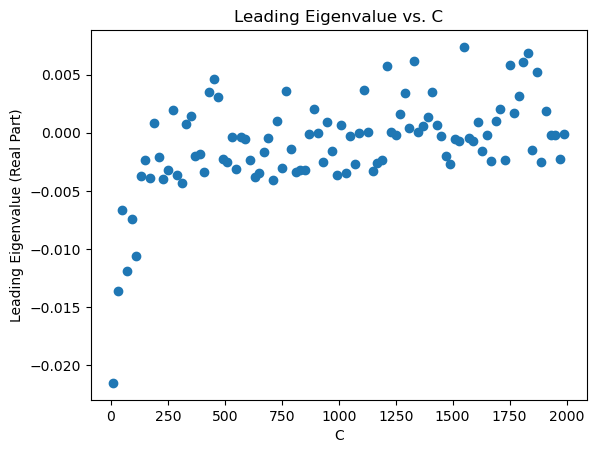

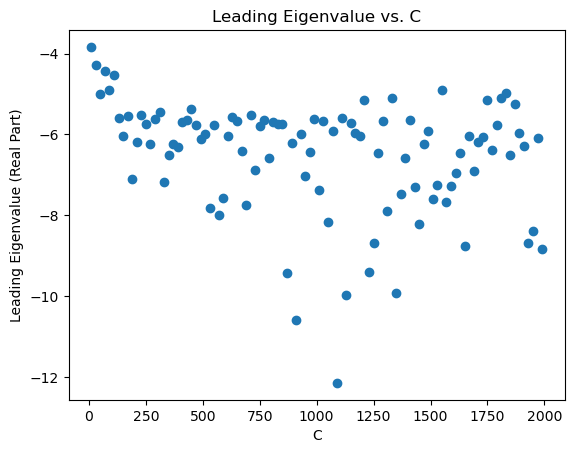

In [8]:
plt.scatter(S, leads)
plt.xlabel("C")
plt.ylabel("Leading Eigenvalue (Real Part)")
plt.title("Leading Eigenvalue vs. C")
plt.show()
plt.scatter(S, logs)
plt.xlabel("C")
plt.ylabel("Leading Eigenvalue (Real Part)")
plt.title("Leading Eigenvalue vs. C")
plt.show()